# Neural Networks: X-ray Pneumonia Binary Classification


---
##  Problem Statement & Evaluation Metrics

**Problem Statement**

Our goal is to correctly identity positive/negative pneumonia cases based on x-ray images. This is a computer vision (image recognition) problem in the healthcare field, in which we will use neural networks to classify x-rays as positive or negative. This could potentially serve as a tool for medical professionsals to aid in diagnosis. Input data and project details can be found at https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.

**Evaluation Metrics**

To correctly classify images as normal vs pneumonia using machine learning, the model will be selected based on an recall. This metric is chosen as a false negative could be potentially damaging and costly if missed (the child has pneumonia and diagnosed as healthy).

# Project Layout

We break the notebook into separate steps. These links navigate the notebook.

* [Step 1](#import): Obtaining Data
* [Step 2](#eda): Exploratory Data Analysis, Augmentation, Preprocessing
* [Step 3](#modeling): Modeling (each has unbalanced then balanced)
    * [Model 1](#NN_baseline):  Neural Network, 2 layers 
    * [Model 2](#NN_drop): Neural Network, 4 layers, dropout  
    * [Model 3](#NN_bn): Neural Network, 4 layers, batch normalization 
    * [Model 4](#CNN): Convolutional Neural Network
    * [Model 5](#transfer_VGG19): Transfer Learning VGG19
    * [Model 6](#transfer_Mobile): Transfer Learning MobilNetV2
* [Evaluation](#evaluation): Evaluation, Discussion, & Next Steps
* [Resources](#resources): Resources

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["axes.grid"] = False
%matplotlib inline   
%config InlineBackend.figure_format = 'retina'

from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report

import os
from glob import glob

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\guy\.conda\envs\deeplearning\lib

In [2]:
# load filenames for human and dog images
normal_files = np.array(glob("data/chest_xray/train/NORMAL/*"))
pneumonia_files = np.array(glob("data/chest_xray/train/pneumonia/*"))

# print number of images in each dataset
print('There are %d total normal x_ray images in the training set.' % len(normal_files)) # normal_files = human_files
print('There are %d total pneumonia x_ray images in the training set.' % len(pneumonia_files)) # pneumonia_files = dog_files

There are 1076 total normal x_ray images in the training set.
There are 3122 total pneumonia x_ray images in the training set.


In [3]:
# load filenames for human and dog images
normal_files = np.array(glob("data/chest_xray/val/NORMAL/*"))
pneumonia_files = np.array(glob("data/chest_xray/val/pneumonia/*"))

# print number of images in each dataset
print('There are %d total normal x_ray images in the validation set.' % len(normal_files)) # normal_files = human_files
print('There are %d total pneumonia x_ray images in the validation set.' % len(pneumonia_files)) # pneumonia_files = dog_files

There are 273 total normal x_ray images in the validation set.
There are 761 total pneumonia x_ray images in the validation set.


This is an imbalanced dataset between the training and validation, introducing bias. As a result, the imbalance was improved to a near 80/20 split due to this large imbalance. 

The original download has only 16 images in validation and 5216 in training. 

---
<a id='eda'></a>
## Exploratory Data Analysis

The following shows the diversity within each image.

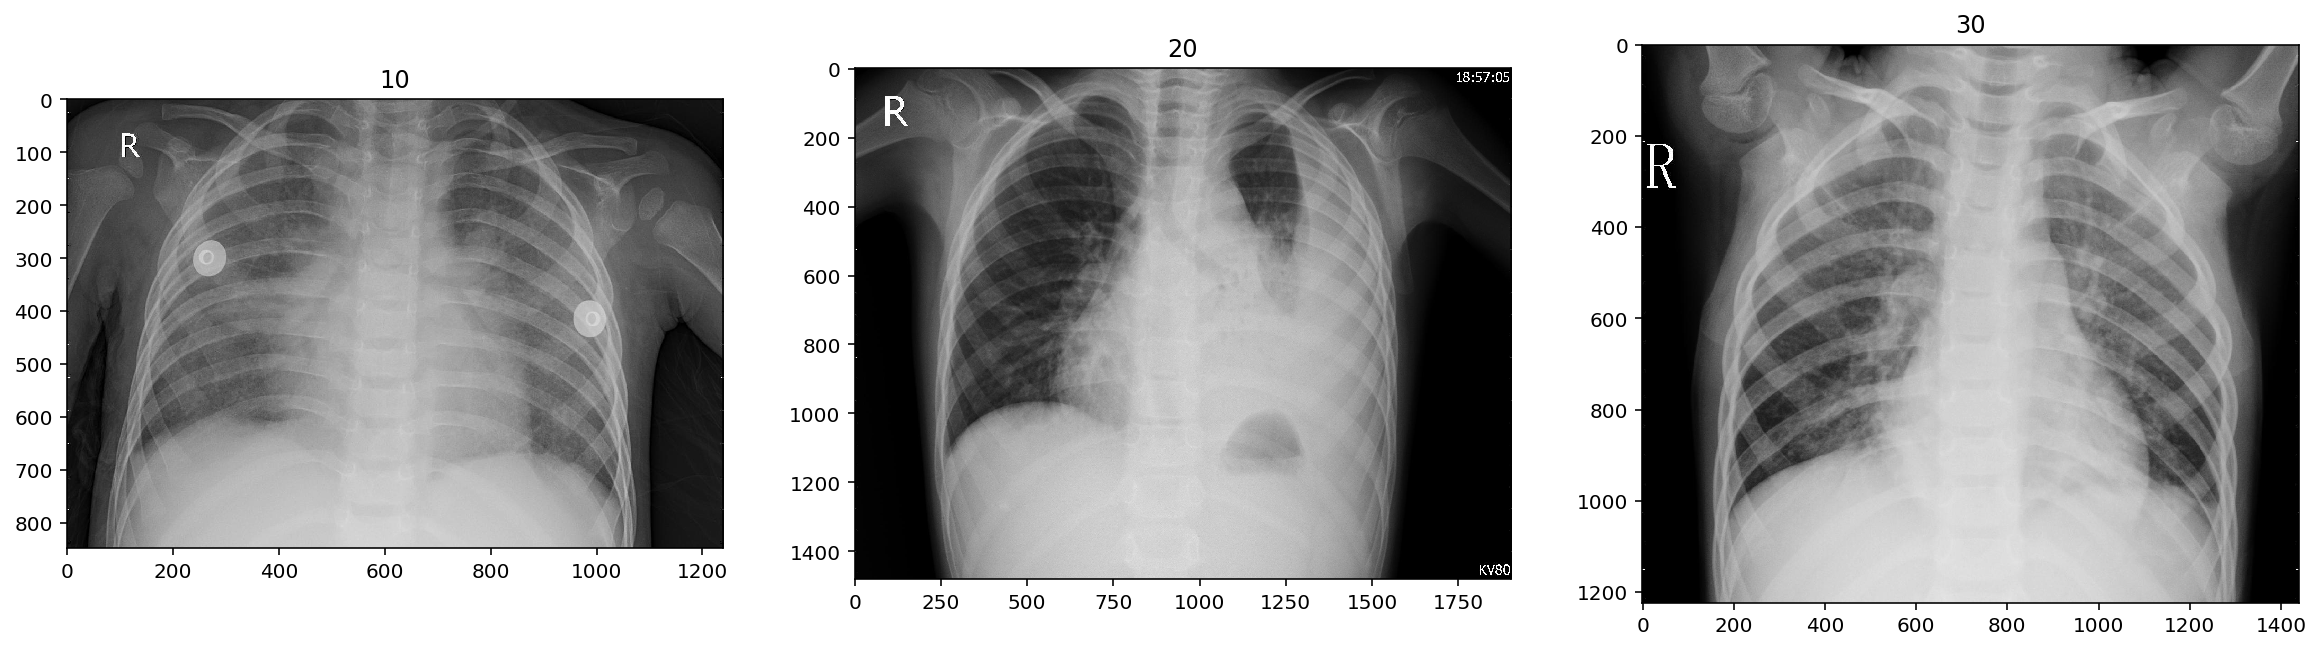

In [4]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

w=300
h=80
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 1
for i in range(1, columns*rows +1):
    img = Image.open(pneumonia_files[i*10])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap = plt.cm.gray)
    plt.title(i*10)
plt.show()

Examining just a few images there are some important elements to note. Much less .... image 3 not as clear....

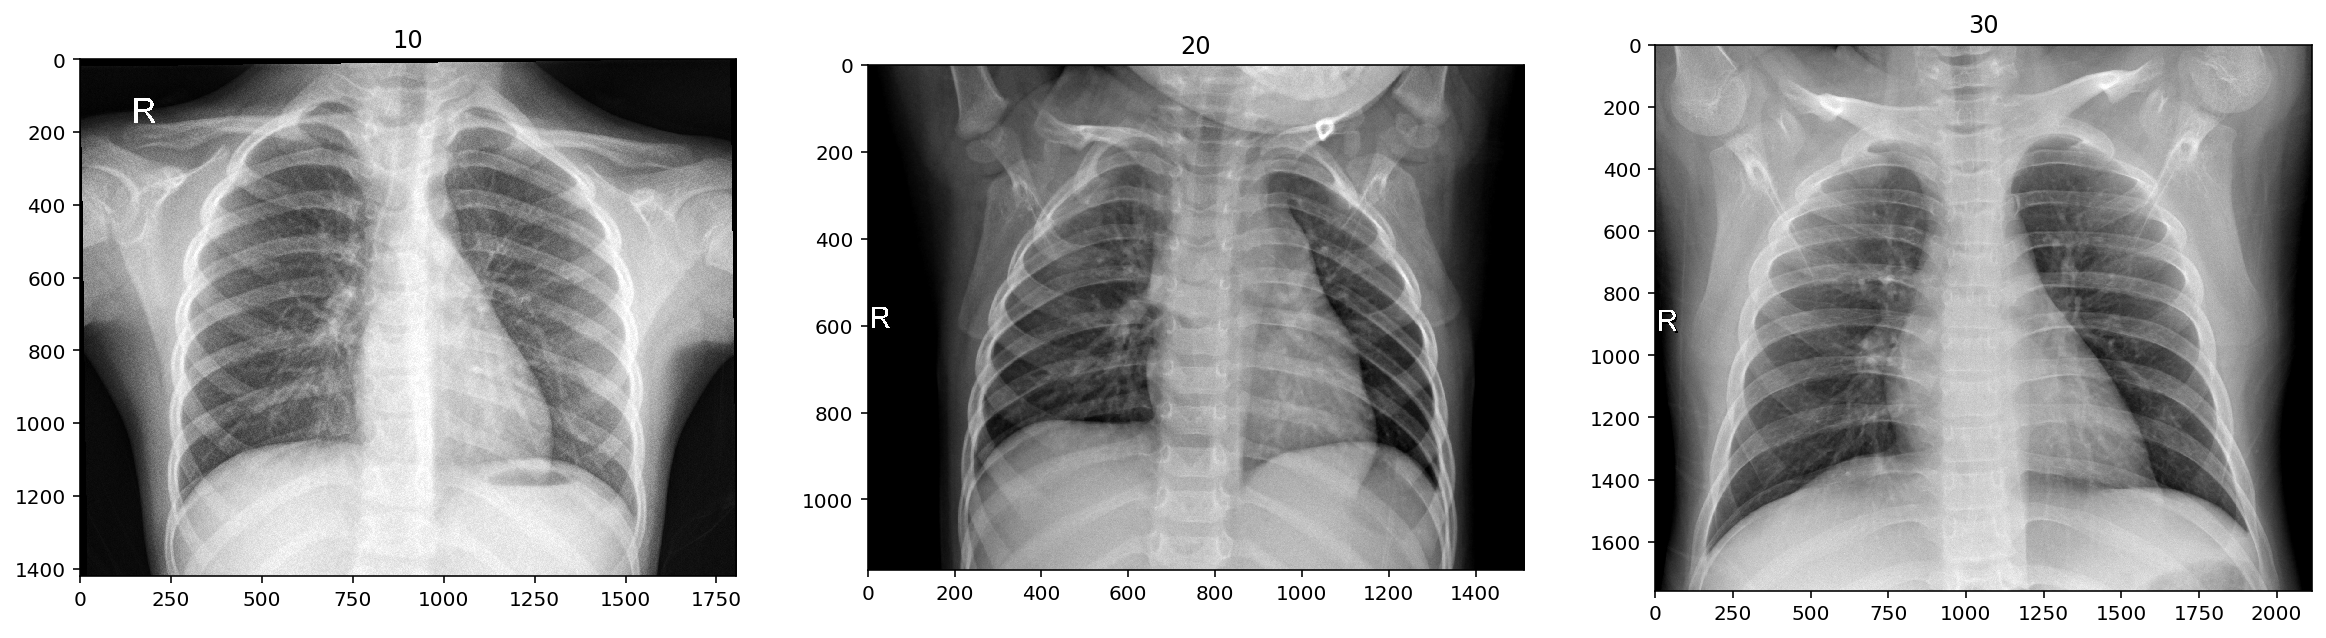

In [5]:
w=300
h=80
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 1
for i in range(1, columns*rows +1):
    img = Image.open(normal_files[i*10])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap = plt.cm.gray)
    plt.title(i*10)
plt.show()

In [6]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2     

width = []
height = []
channels = []

for i in range(len(pneumonia_files)):
    img = cv2.imread(pneumonia_files[i])
    dimensions = img.shape
    width.append(dimensions[0])
    height.append(dimensions[1])
    channels.append(dimensions[2])

In [7]:
df = pd.DataFrame(list(zip(width, height, channels)), columns = ['Width (pixels)', 'Height (pixels)','Channels (RGB)'])
df.describe()

,Width (pixels),Height (pixels),Channels (RGB)
count,761.000000,761.000000,761.0
mean,868.007884,1259.551905,3.0
std,322.857896,326.300774,0.0
min,144.000000,399.000000,3.0
25%,672.000000,1064.000000,3.0
50%,824.000000,1248.000000,3.0
75%,1048.000000,1464.000000,3.0
max,2272.000000,2192.000000,3.0


The following shows the range of input images in our data that we will use to train, validate, and test the model. All images are three channels, which indicates RGB, but is in grayscale, so not sure why not 2 channels. The "width" dimension has an average of 825 pixels and "height" dimension of 1200 pixels. However, statistically speaking, there is a lot of variation in the data. So, what does this mean to us? Some images have more information than others. Preprocessing steps may affect some images differently, and resizing will be necessary. (not this is only the training data)

Text(0.5, 0, 'Height (pixels)')

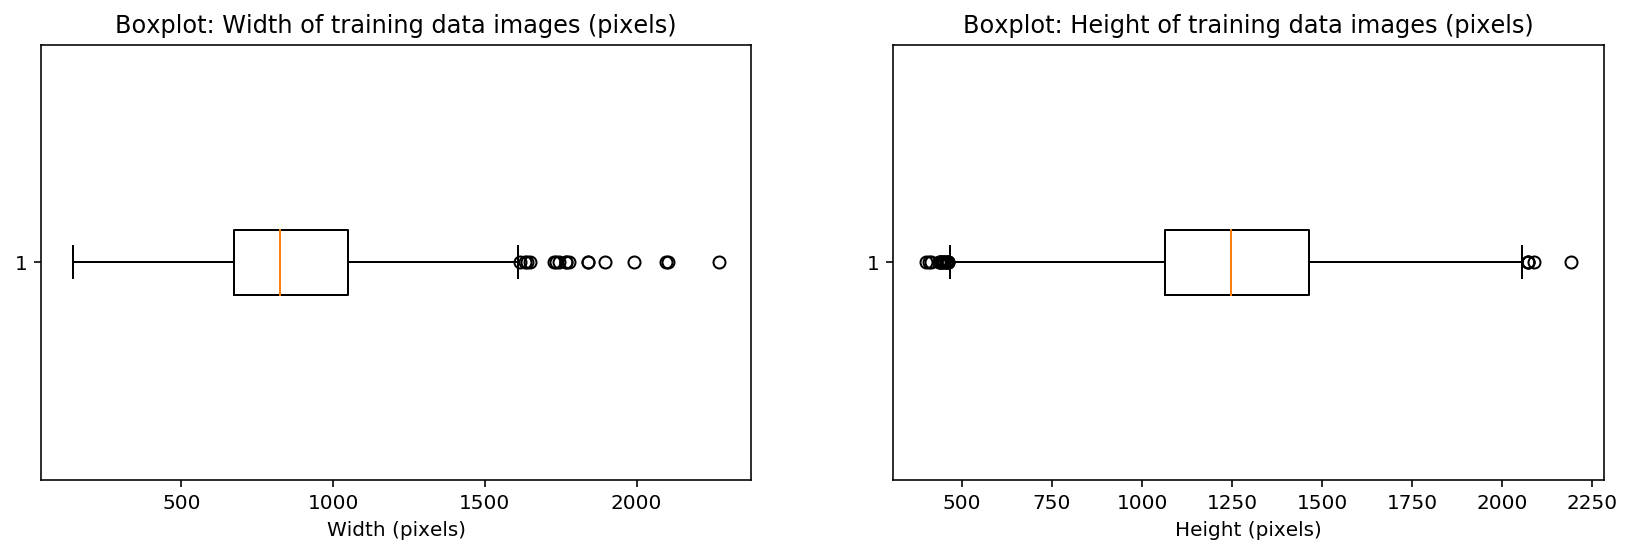

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Define figure and subplot
new_figure = plt.figure(figsize=(14,4))
ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

ax.boxplot(df['Width (pixels)'], vert = False)
ax.set_title('Boxplot: Width of training data images (pixels)')
ax.set_xlabel('Width (pixels)')

ax2.boxplot(df['Height (pixels)'], vert = False)
ax2.set_title('Boxplot: Height of training data images (pixels)')
ax2.set_xlabel('Height (pixels)')

In [9]:
train_dir = 'data/chest_xray/train'
validation_dir = 'data/chest_xray/val'
test_dir = 'data/chest_xray/test'

num_samples = len(pneumonia_files) + len(normal_files)
batch_size = 24

# All images will be rescaled by 1./255, data augmentation for training dataset
train_datagen = ImageDataGenerator(rescale=1./255, # 255 for scaling the 0-256 RGB values
                                  rotation_range = 10, #10 degree rotation
                                  zoom_range=0.2, #zoom up to 20%
                                  shear_range=0.1 #rotation plan 10%
                                  ) 

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),         # All images will be resized to 224X224
        batch_size= batch_size, 
        class_mode='binary') #binary_crossentropy loss, we need binary labe

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size= batch_size,
        class_mode='binary')

# test generator
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(224, 224), 
        batch_size= 1,
        shuffle= False,
        class_mode='binary')

Found 4198 images belonging to 2 classes.
Found 1034 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Getting the class weights for an imbalanced trainining dataset

In [10]:
NORMAL = 1076
PNEUMONIA = 3122

wgt = PNEUMONIA/NORMAL
wgt

2.9014869888475836

In [11]:
training_class_weight = {0: wgt, 1: 1.}
#training_class_weight = {'NORMAL': wgt, 'PNEUMONIA': 1.} #this throws an error
training_class_weight

{0: 2.9014869888475836, 1: 1.0}

# Helper Functions

In [12]:
# Visualizing model train/validation accuracy
def plot_acc_val(hist):
    '''takes fitted history object, and returns 2 plots by epoch, 1 for loss the other accuracy'''
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    # Define figure and subplot
    new_figure = plt.figure(figsize=(14,4))
    ax = new_figure.add_subplot(121)
    ax2 = new_figure.add_subplot(122)

    # Loss Plot
    ax.plot(train_losses,  color='blue', linewidth=3, linestyle = '-')
    ax.plot(val_losses,  color='orange', linewidth=3, linestyle = '-')
    ax.set_title('Loss: Training vs Validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(('Train','Valid'), frameon = False)

    # Accuracy Plot
    ax2.plot(acc,  color='blue', linewidth=3, linestyle = '-.')
    ax2.plot(val_acc,  color='orange', linewidth=3, linestyle = '-.')
    ax2.set_title('Accuracy: Training vs Validation')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(('Train','Valid'), frameon = False)
    #plt.show()
    return(plt)


# Evaluation metrics
def evaluate_test_saved_model(path):
    ''' load a saved model (filepath), predict on test data, and return evaluation metrics as a list
        INPUT: path = 'static/artifacts/weights_best.hdf5'
        OUTPUT: list of performance metrics
    '''
    loaded = load_model(path)
    
    # predictions
    y_pred = loaded.predict_generator(test_generator, steps = 624)
    preds = np.rint(y_pred)

    # true labels
    labels=test_generator.classes
    
    return [precision_score(labels, preds), recall_score(labels, preds), accuracy_score(labels, preds), f1_score(labels, preds)]


---
<a id='modeling'></a>
# Modeling

<a id='NN_baseline'></a>
# Baseline: Neural Network, MLP

W0504 18:18:05.096057 17212 deprecation_wrapper.py:119] From C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0504 18:18:05.109002 17212 deprecation_wrapper.py:119] From C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0504 18:18:05.110996 17212 deprecation_wrapper.py:119] From C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0504 18:18:05.165850 17212 deprecation_wrapper.py:119] From C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0504 18:18:05.170838 17212 


Epoch 00001: val_acc improved from -inf to 0.79117, saving model to static/artifacts/model_nn_2h_baseline.hdf5

Epoch 00002: val_acc improved from 0.79117 to 0.89474, saving model to static/artifacts/model_nn_2h_baseline.hdf5

Epoch 00003: val_acc improved from 0.89474 to 0.90068, saving model to static/artifacts/model_nn_2h_baseline.hdf5

Epoch 00004: val_acc did not improve from 0.90068

Epoch 00005: val_acc did not improve from 0.90068

Epoch 00006: val_acc did not improve from 0.90068

Epoch 00007: val_acc did not improve from 0.90068

Epoch 00008: val_acc did not improve from 0.90068

Epoch 00009: val_acc improved from 0.90068 to 0.91426, saving model to static/artifacts/model_nn_2h_baseline.hdf5

Epoch 00010: val_acc did not improve from 0.91426


<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

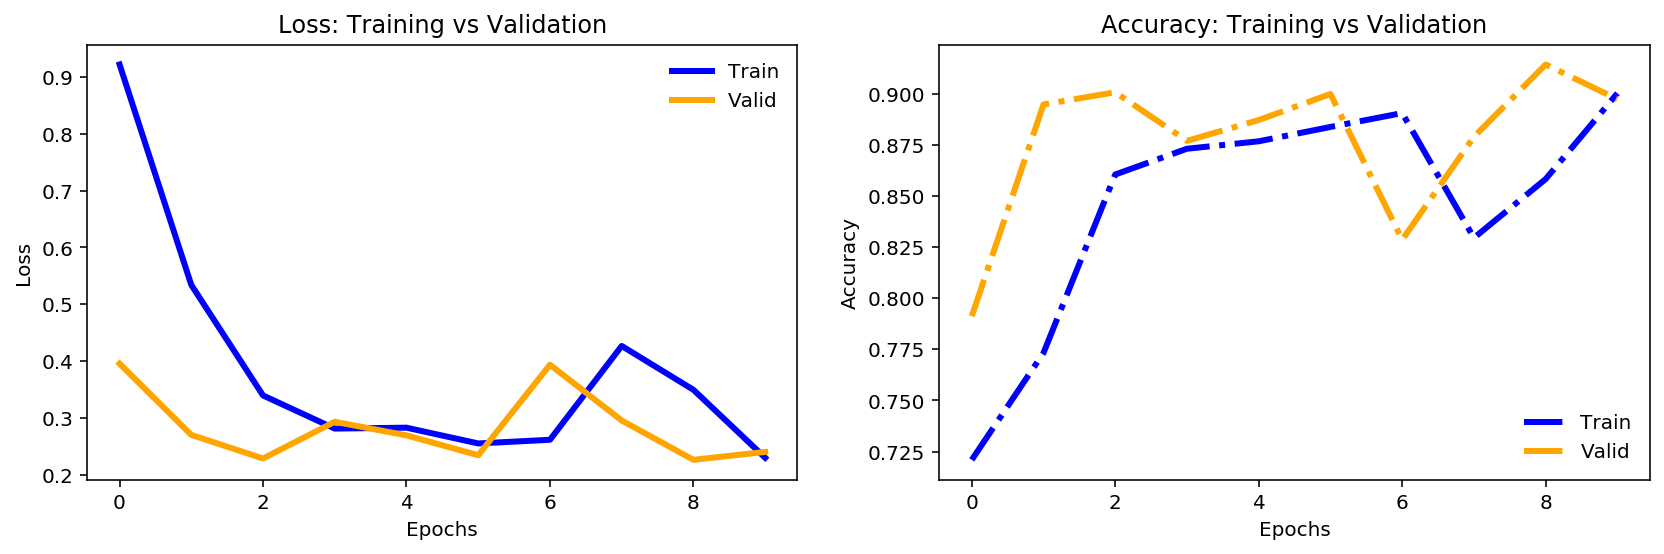

In [13]:
epochs = 10
early_stopping_monitor = EarlyStopping(patience=2) # epochs no improvement

model = models.Sequential()
model.add(layers.Dense(32, activation='relu',input_shape=(224, 224, 3)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(lr=0.0001) # decreased learning rate due to oscillating 

model.compile(loss='binary_crossentropy',
              optimizer= optimizer,
              metrics=['accuracy'])

#saving weights checkpoints
filepath="static/artifacts/model_nn_2h_baseline.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False,  mode='max')

#Set the model to train
history = model.fit_generator(
      train_generator,
      steps_per_epoch= num_samples // batch_size,
      # class_weight=training_class_weight,
      epochs=epochs,
      verbose=0,
      shuffle=True,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint]) # [early_stopping_monitor]

#Visualing the model loss and accuracy.

plot_acc_val(history)

### Balanced Dataset Fitting


Epoch 00001: val_acc improved from -inf to 0.86672, saving model to static/artifacts/model_nn_2h_baseline_balanced.hdf5

Epoch 00002: val_acc did not improve from 0.86672

Epoch 00003: val_acc did not improve from 0.86672

Epoch 00004: val_acc improved from 0.86672 to 0.90407, saving model to static/artifacts/model_nn_2h_baseline_balanced.hdf5

Epoch 00005: val_acc improved from 0.90407 to 0.90571, saving model to static/artifacts/model_nn_2h_baseline_balanced.hdf5

Epoch 00006: val_acc did not improve from 0.90571

Epoch 00007: val_acc improved from 0.90571 to 0.91256, saving model to static/artifacts/model_nn_2h_baseline_balanced.hdf5

Epoch 00008: val_acc did not improve from 0.91256

Epoch 00009: val_acc did not improve from 0.91256

Epoch 00010: val_acc did not improve from 0.91256


<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

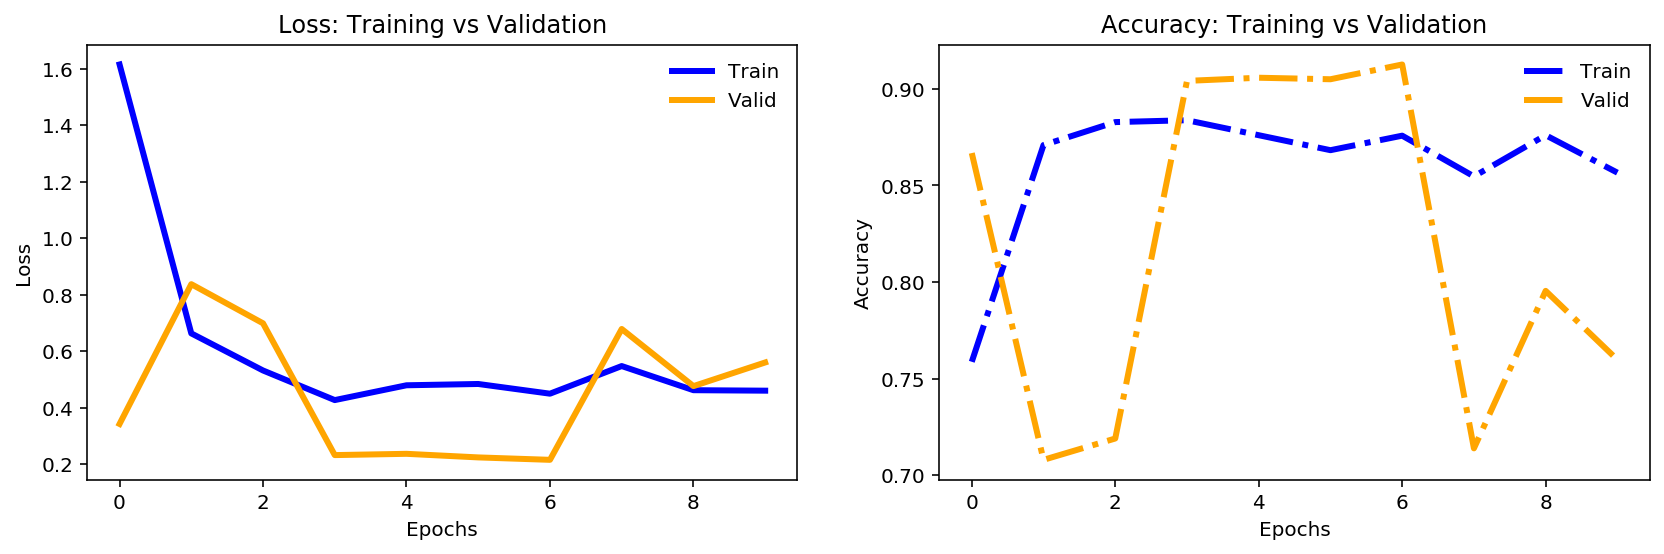

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer= optimizer,
              metrics=['accuracy'])

#saving weights checkpoints
filepath="static/artifacts/model_nn_2h_baseline_balanced.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False,  mode='max')


#Set the model to train
history = model.fit_generator(
      train_generator,
      steps_per_epoch= num_samples // batch_size,
      class_weight=training_class_weight,
      epochs=epochs,
      shuffle=True,
      verbose=0,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint]) # [early_stopping_monitor]

# Visualing the model loss and accuracy.
plot_acc_val(history)

---
<a id='NN_drop'></a>
# Neural Network, MLP
- Four hidden layers, added dropout as well

W0504 18:34:23.446672 17212 deprecation.py:506] From C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Epoch 00001: val_acc improved from -inf to 0.58829, saving model to static/artifacts/model_nn_4h_dropout.hdf5

Epoch 00002: val_acc improved from 0.58829 to 0.75519, saving model to static/artifacts/model_nn_4h_dropout.hdf5

Epoch 00003: val_acc improved from 0.75519 to 0.78353, saving model to static/artifacts/model_nn_4h_dropout.hdf5

Epoch 00004: val_acc improved from 0.78353 to 0.83616, saving model to static/artifacts/model_nn_4h_dropout.hdf5

Epoch 00005: val_acc improved from 0.83616 to 0.84720, saving model to static/artifacts/model_nn_4h_dropout.hdf5

Epoch 00006: val_acc did not improve from 0.84720

Epoch 00007: val_acc did not improve from 0.84720

Epoch 00008: val_acc did not improve from 0.84720

Epoch 00009: val_acc improved from 0.84720 to 0.89792, saving model to static/artifacts/model_nn_4h_dropout.hdf5

Epoch 00010: val_acc did not improve from 0.89792


<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

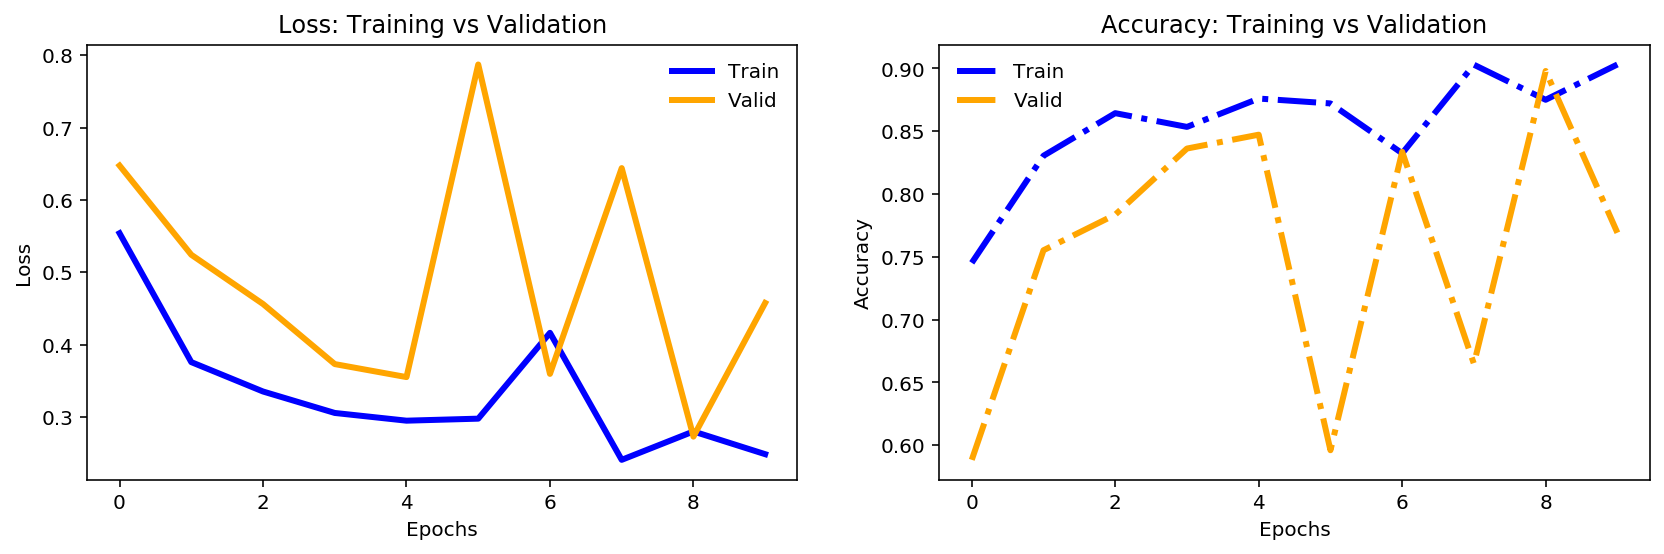

In [15]:
model2 = models.Sequential()
model2.add(layers.Dense(32, activation='relu',input_shape=(224, 224, 3)))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(lr=0.0001) # decreased learning rate due to oscillating 

#saving weights checkpoints
filepath="static/artifacts/model_nn_4h_dropout.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')

model2.compile(loss='binary_crossentropy',
              optimizer= optimizer, 
              metrics=['accuracy'])

#Set the model2 to train
history = model2.fit_generator(
      train_generator,
      steps_per_epoch= num_samples // batch_size,
      epochs=epochs,
      shuffle=True,
      verbose=0,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint]) # [early_stopping_monitor]


# Visualing the model loss and accuracy.
plot_acc_val(history)

### Balanced Dataset Fitting


Epoch 00001: val_acc improved from -inf to 0.60441, saving model to static/artifacts/model_nn_4h_dropout_balanced.hdf5

Epoch 00002: val_acc improved from 0.60441 to 0.66214, saving model to static/artifacts/model_nn_4h_dropout_balanced.hdf5

Epoch 00003: val_acc did not improve from 0.66214

Epoch 00004: val_acc did not improve from 0.66214

Epoch 00005: val_acc did not improve from 0.66214

Epoch 00006: val_acc did not improve from 0.66214

Epoch 00007: val_acc did not improve from 0.66214

Epoch 00008: val_acc did not improve from 0.66214

Epoch 00009: val_acc did not improve from 0.66214

Epoch 00010: val_acc did not improve from 0.66214


<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

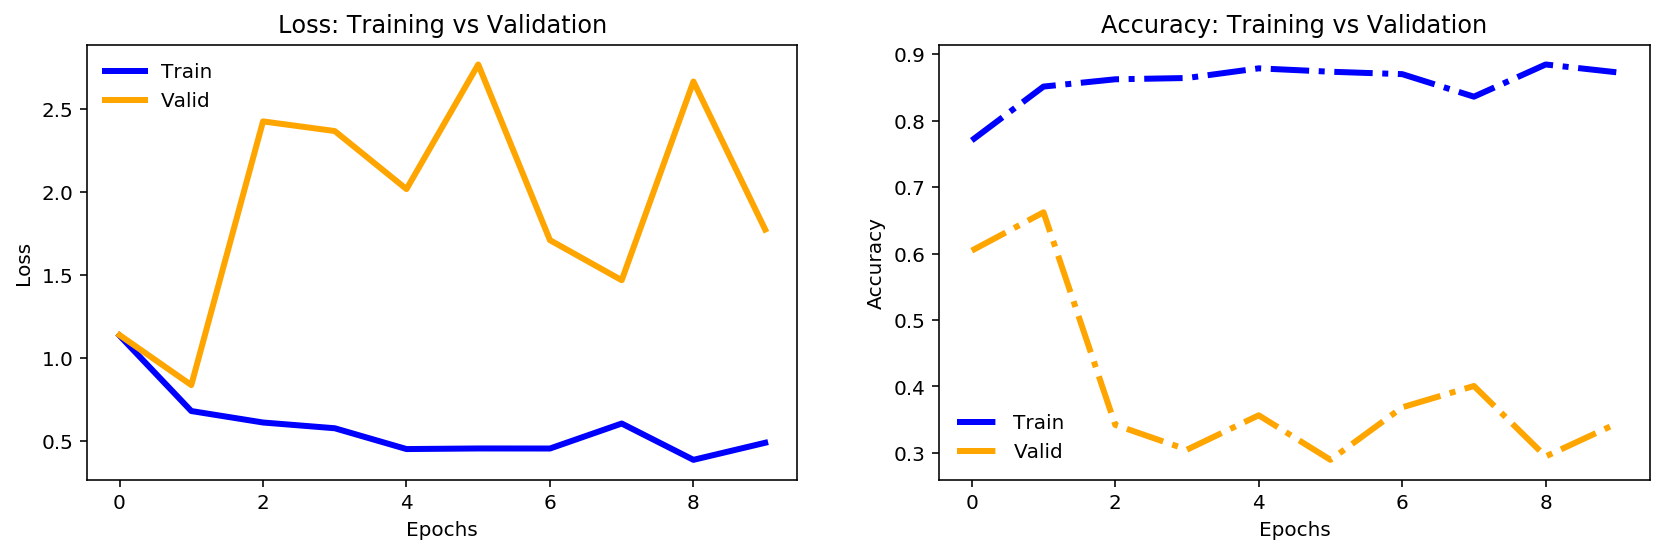

In [17]:
#saving weights checkpoints
filepath="static/artifacts/model_nn_4h_dropout_balanced.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')

model2.compile(loss='binary_crossentropy',
              optimizer= optimizer, 
              metrics=['accuracy'])

#Set the model2 to train
history = model2.fit_generator(
      train_generator,
      steps_per_epoch= num_samples // batch_size,
      class_weight=training_class_weight,
      epochs=epochs,
      shuffle=True,
      verbose=0,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint]) # [early_stopping_monitor]


# Visualing the model loss and accuracy.
plot_acc_val(history)

---
<a id='NN_bn'></a>
# Neural Network, MLP
- Four hidden layers, batch normalization

W0504 19:15:59.172029 17212 deprecation_wrapper.py:119] From C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.




Epoch 00001: val_acc improved from -inf to 0.74278, saving model to static/artifacts/model_nn_4h__batchnorm.hdf5

Epoch 00002: val_acc did not improve from 0.74278

Epoch 00003: val_acc did not improve from 0.74278

Epoch 00004: val_acc did not improve from 0.74278

Epoch 00005: val_acc did not improve from 0.74278

Epoch 00006: val_acc improved from 0.74278 to 0.74703, saving model to static/artifacts/model_nn_4h__batchnorm.hdf5

Epoch 00007: val_acc did not improve from 0.74703

Epoch 00008: val_acc did not improve from 0.74703

Epoch 00009: val_acc did not improve from 0.74703

Epoch 00010: val_acc improved from 0.74703 to 0.74788, saving model to static/artifacts/model_nn_4h__batchnorm.hdf5


<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

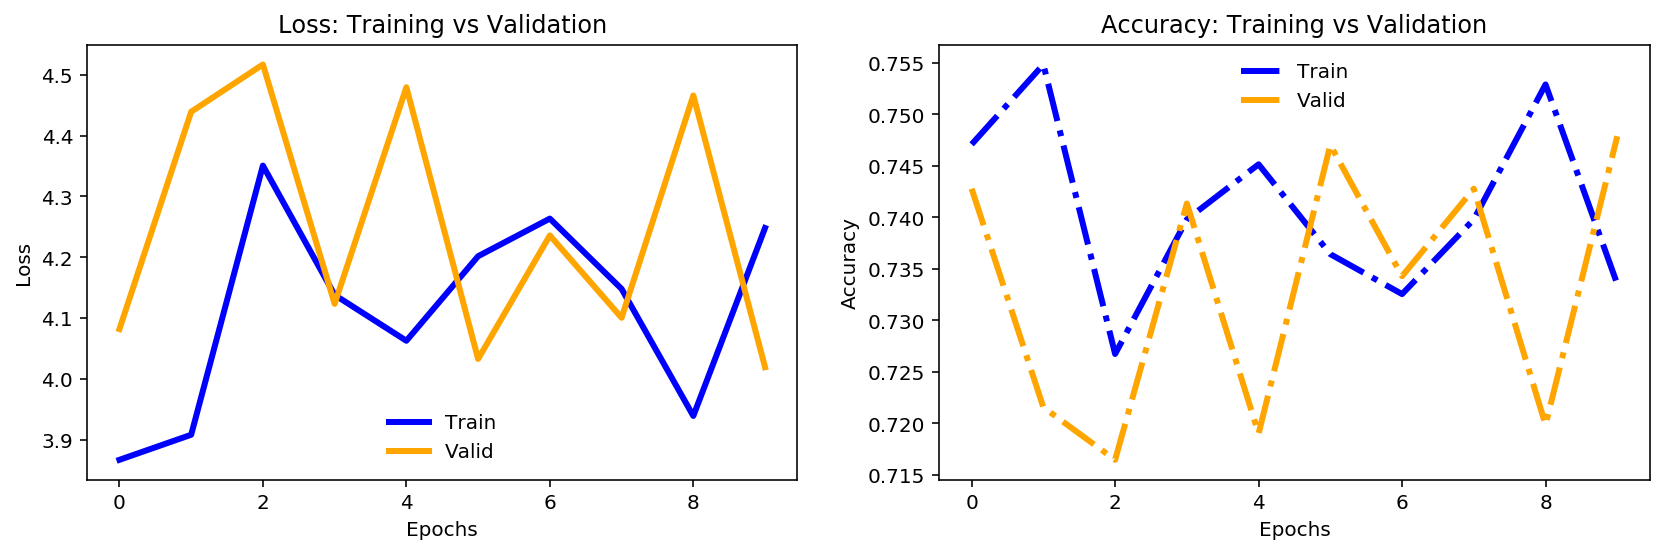

In [18]:
model3 = models.Sequential()
model3.add(layers.Dense(32, input_shape=(224, 224, 3)))
model3.add(Activation("relu"))
model3.add(layers.BatchNormalization())

model3.add(layers.Dense(32))
model3.add(Activation("relu"))
model3.add(layers.BatchNormalization())

model3.add(layers.Dense(32))
model3.add(Activation("relu"))
model3.add(layers.BatchNormalization())

model3.add(layers.Dense(32))
model3.add(Activation("relu"))
model3.add(layers.BatchNormalization())

model3.add(layers.Flatten())
model3.add(layers.Dense(1, activation='sigmoid'))

#saving weights checkpoints
filepath="static/artifacts/model_nn_4h__batchnorm.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')

optimizer = optimizers.Adam(lr=0.0001) # decreased learning rate due to oscillating 

model3.compile(loss='binary_crossentropy',
              optimizer= optimizer, 
              metrics=['accuracy'])

#Set the model3 to train
history = model3.fit_generator(
      train_generator,
      steps_per_epoch= num_samples // batch_size,
      epochs=epochs,
      verbose=0,
      shuffle = True,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint]) # [early_stopping_monitor]


# Visualing the model loss and accuracy.
plot_acc_val(history)

### Balanced Dataset Fitting


Epoch 00001: val_acc improved from -inf to 0.74448, saving model to static/artifacts/model_nn_4h__batchnorm_balanced.hdf5

Epoch 00002: val_acc improved from 0.74448 to 0.75806, saving model to static/artifacts/model_nn_4h__batchnorm_balanced.hdf5

Epoch 00003: val_acc improved from 0.75806 to 0.75891, saving model to static/artifacts/model_nn_4h__batchnorm_balanced.hdf5

Epoch 00004: val_acc improved from 0.75891 to 0.78287, saving model to static/artifacts/model_nn_4h__batchnorm_balanced.hdf5

Epoch 00005: val_acc improved from 0.78287 to 0.83956, saving model to static/artifacts/model_nn_4h__batchnorm_balanced.hdf5

Epoch 00006: val_acc improved from 0.83956 to 0.85484, saving model to static/artifacts/model_nn_4h__batchnorm_balanced.hdf5

Epoch 00007: val_acc improved from 0.85484 to 0.89898, saving model to static/artifacts/model_nn_4h__batchnorm_balanced.hdf5

Epoch 00008: val_acc did not improve from 0.89898

Epoch 00009: val_acc did not improve from 0.89898

Epoch 00010: val_a

<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

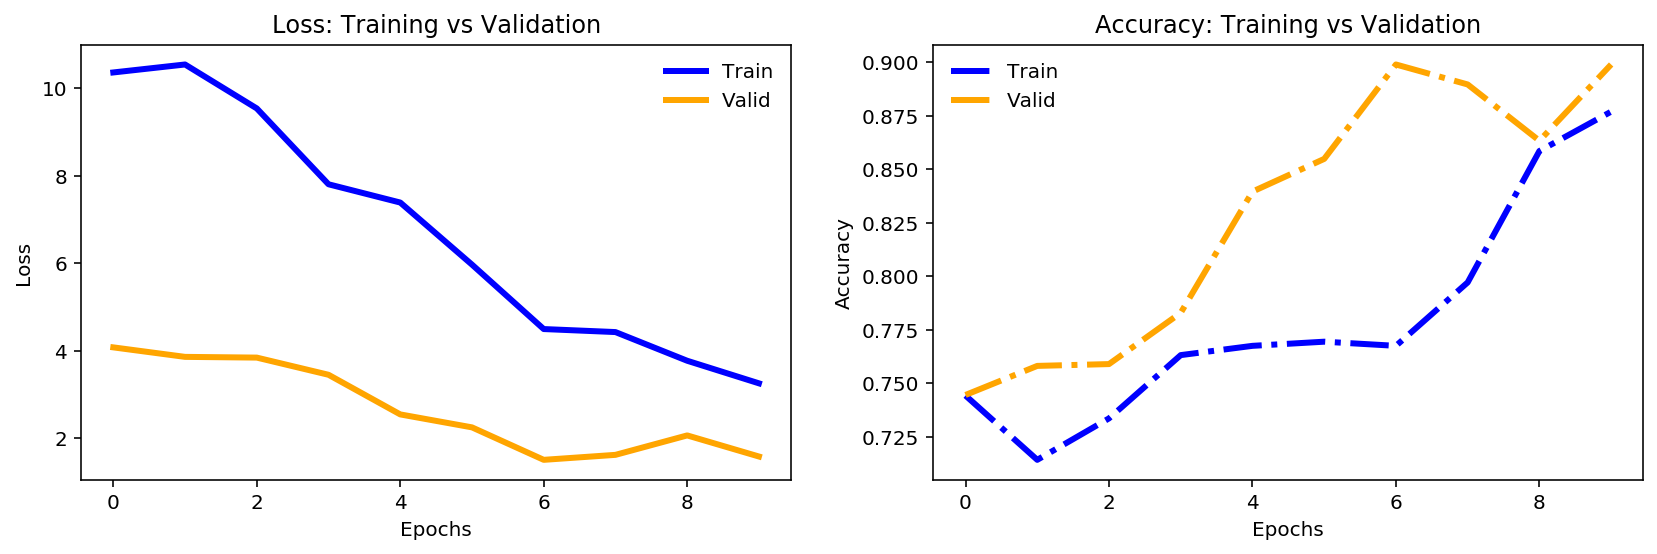

In [21]:
#saving weights checkpoints
filepath="static/artifacts/model_nn_4h__batchnorm_balanced.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')

optimizer = optimizers.Adam(lr=0.0001) # decreased learning rate due to oscillating 

model3.compile(loss='binary_crossentropy',
              optimizer= optimizer, 
              metrics=['accuracy'])

#Set the model3 to train
history = model3.fit_generator(
      train_generator,
      steps_per_epoch= num_samples // batch_size,
      class_weight=training_class_weight,
      epochs=epochs,
      verbose=0,
      shuffle = True,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint]) # [early_stopping_monitor]


# Visualing the model loss and accuracy.
plot_acc_val(history)

---
<a id='CNN'></a>
# CNN

W0504 22:36:05.178508 17212 deprecation_wrapper.py:119] From C:\Users\guy\.conda\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.




Epoch 00001: val_acc improved from -inf to 0.73514, saving model to static/artifacts/model_cnn.hdf5

Epoch 00002: val_acc improved from 0.73514 to 0.73854, saving model to static/artifacts/model_cnn.hdf5

Epoch 00003: val_acc improved from 0.73854 to 0.80051, saving model to static/artifacts/model_cnn.hdf5

Epoch 00004: val_acc improved from 0.80051 to 0.80645, saving model to static/artifacts/model_cnn.hdf5

Epoch 00005: val_acc improved from 0.80645 to 0.83616, saving model to static/artifacts/model_cnn.hdf5

Epoch 00006: val_acc did not improve from 0.83616

Epoch 00007: val_acc improved from 0.83616 to 0.89273, saving model to static/artifacts/model_cnn.hdf5

Epoch 00008: val_acc improved from 0.89273 to 0.90068, saving model to static/artifacts/model_cnn.hdf5

Epoch 00009: val_acc did not improve from 0.90068

Epoch 00010: val_acc did not improve from 0.90068


<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

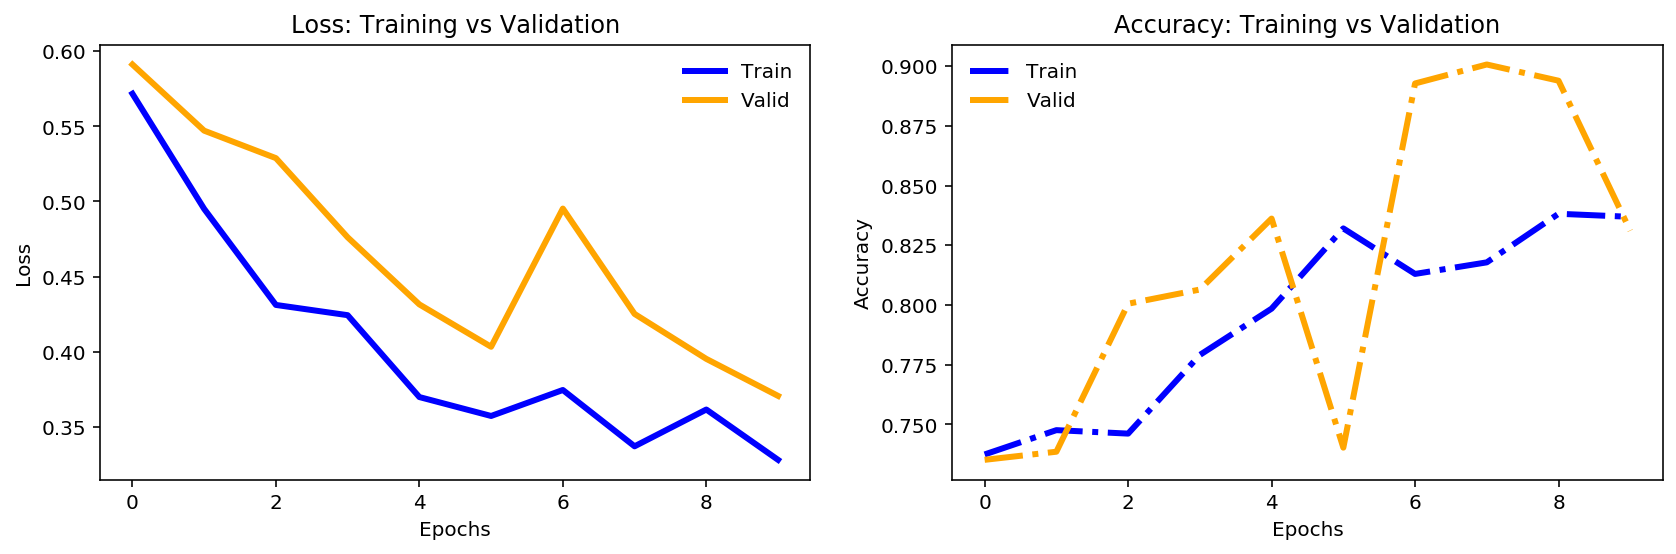

In [22]:
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
    
early_stopping_monitor = EarlyStopping(patience=2) # 2 epochs no improvement

model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(Dropout(0.25))
model5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(Dropout(0.25))
model5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Flatten())
model5.add(layers.Dense(50, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))


optimizer = optimizers.Adam(lr=0.0001) # decreased learning rate due to oscillating 

model5.compile(loss='binary_crossentropy',
              optimizer= optimizer, 
              metrics=['accuracy'])

#saving weights checkpoints
filepath="static/artifacts/model_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')

#Set the model5 to train
history = model5.fit_generator(
      train_generator,
      steps_per_epoch= num_samples // batch_size,
      epochs=epochs,
      shuffle = True,
      verbose=0,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint]) # [early_stopping_monitor]

plot_acc_val(history)

### Balanced Dataset Fitting


Epoch 00001: val_acc improved from -inf to 0.27165, saving model to static/artifacts/model_cnn_balanced.hdf5

Epoch 00002: val_acc did not improve from 0.27165

Epoch 00003: val_acc improved from 0.27165 to 0.83956, saving model to static/artifacts/model_cnn_balanced.hdf5

Epoch 00004: val_acc improved from 0.83956 to 0.85381, saving model to static/artifacts/model_cnn_balanced.hdf5

Epoch 00005: val_acc improved from 0.85381 to 0.85993, saving model to static/artifacts/model_cnn_balanced.hdf5

Epoch 00006: val_acc improved from 0.85993 to 0.89983, saving model to static/artifacts/model_cnn_balanced.hdf5

Epoch 00007: val_acc did not improve from 0.89983

Epoch 00008: val_acc did not improve from 0.89983

Epoch 00009: val_acc did not improve from 0.89983

Epoch 00010: val_acc did not improve from 0.89983


<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

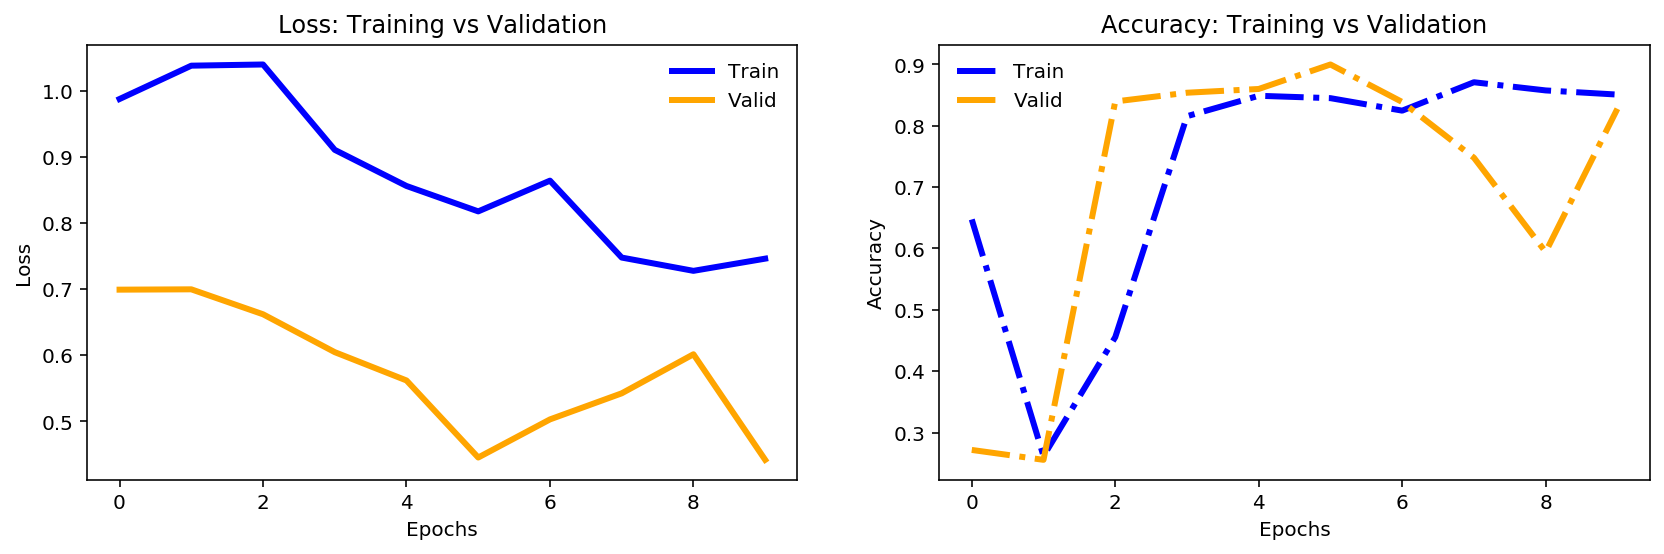

In [23]:
model5.compile(loss='binary_crossentropy',
              optimizer= optimizer, 
              metrics=['accuracy'])

#saving weights checkpoints
filepath="static/artifacts/model_cnn_balanced.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')

#Set the model5 to train
history = model5.fit_generator(
      train_generator,
      steps_per_epoch= num_samples // batch_size,
      epochs=epochs,
      class_weight=training_class_weight,
      verbose=0,
      shuffle = True,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint]) # [early_stopping_monitor]

plot_acc_val(history)

---
<a id='transfer_VGG19'></a>
# Transfer Learning - VGG19

In [26]:
#Initialize Base
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

#Define Model Architecture
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

cnn_base.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                1605696   
_________________________________________________________________
dense_22 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_23 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total para


Epoch 00001: val_acc improved from -inf to 0.93718, saving model to static/artifacts/model_transfer.hdf5

Epoch 00002: val_acc did not improve from 0.93718

Epoch 00003: val_acc improved from 0.93718 to 0.94058, saving model to static/artifacts/model_transfer.hdf5

Epoch 00004: val_acc improved from 0.94058 to 0.95161, saving model to static/artifacts/model_transfer.hdf5

Epoch 00005: val_acc improved from 0.95161 to 0.95501, saving model to static/artifacts/model_transfer.hdf5

Epoch 00006: val_acc improved from 0.95501 to 0.95502, saving model to static/artifacts/model_transfer.hdf5

Epoch 00007: val_acc did not improve from 0.95502


<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

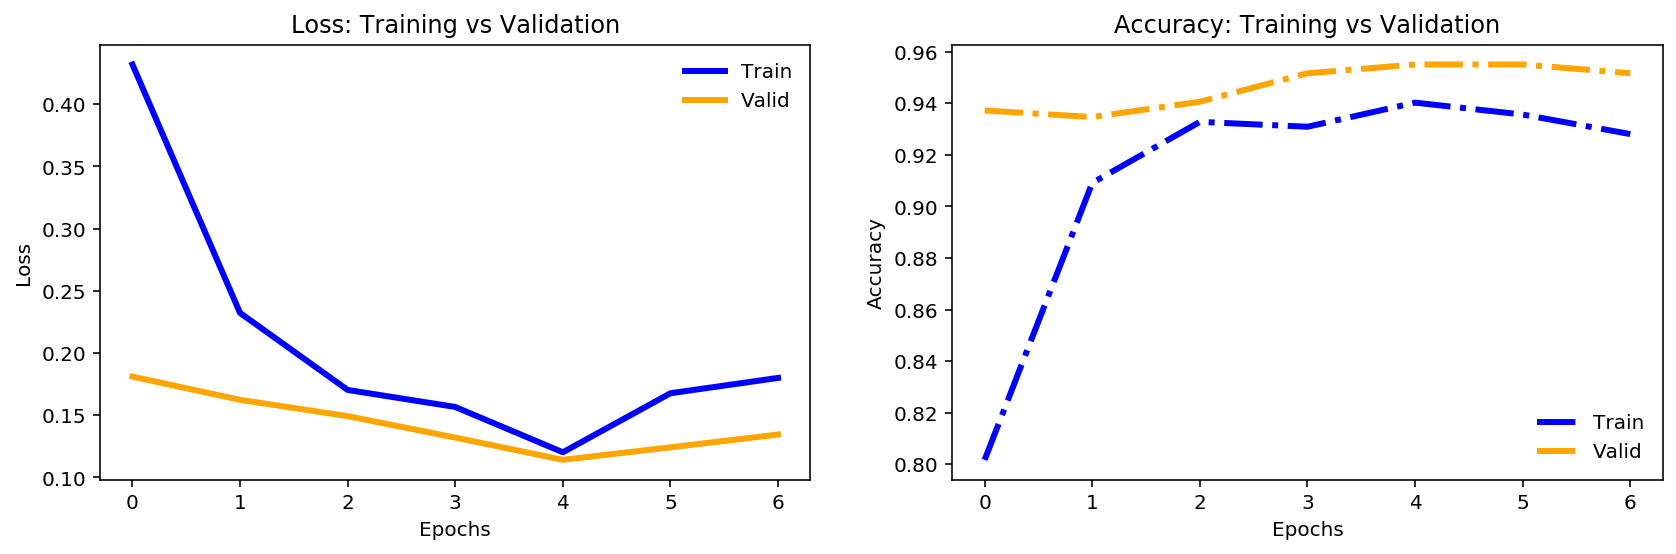

In [27]:
early_stopping_monitor = EarlyStopping(patience=2) # epochs no improvement

filepath="static/artifacts/model_transfer.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')


#Compilation
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Set the model to train; see warnings above
history = model.fit_generator(
      train_generator,
      steps_per_epoch= num_samples / batch_size,
      epochs=epochs,
      verbose = 0,
      shuffle = True,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint,early_stopping_monitor])

plot_acc_val(history)

### Balanced Dataset Fitting


Epoch 00001: val_acc improved from -inf to 0.95416, saving model to static/artifacts/model_transfer_balanced.hdf5

Epoch 00002: val_acc did not improve from 0.95416

Epoch 00003: val_acc did not improve from 0.95416


<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

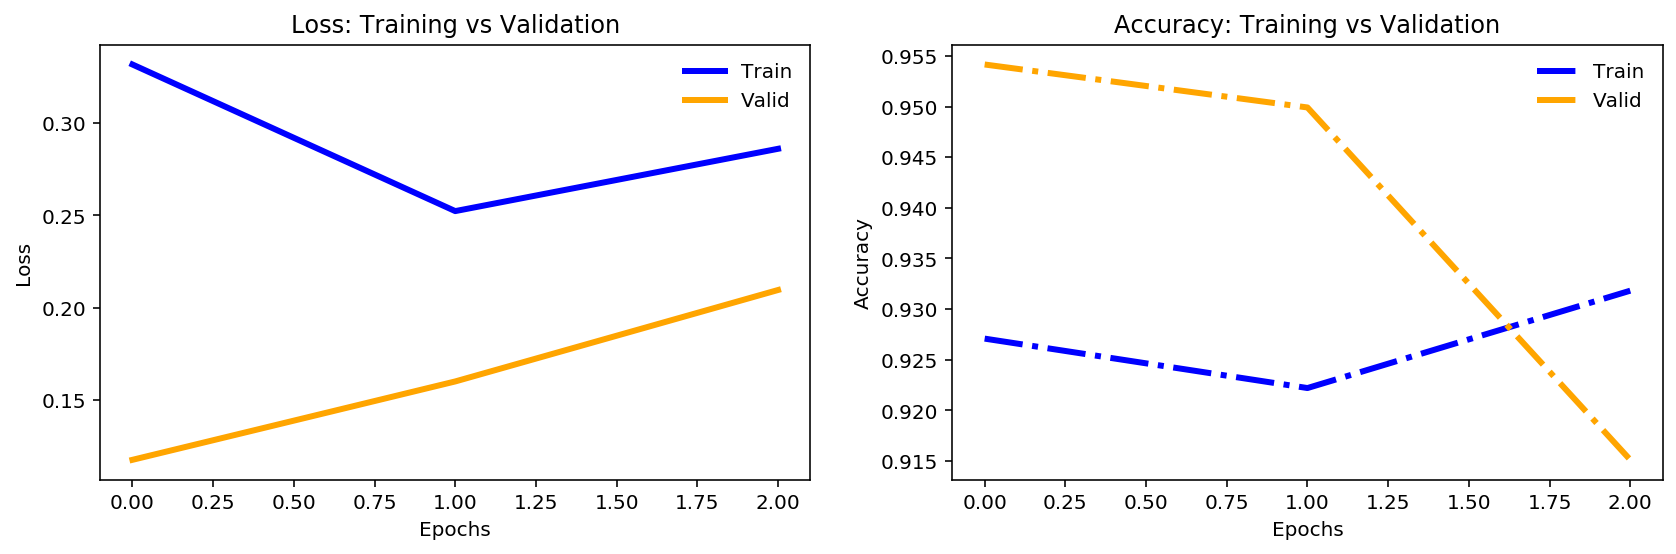

In [28]:
filepath="static/artifacts/model_transfer_balanced.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')


#Compilation
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Set the model to train; see warnings above
history = model.fit_generator(
      train_generator,
      steps_per_epoch= num_samples / batch_size,
      epochs=epochs,
      verbose = 0,
      shuffle = True,
      class_weight=training_class_weight,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint,early_stopping_monitor])

plot_acc_val(history)

---
<a id='transfer_Mobile'></a>
# Transfer Learning - MobileNetV2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_8 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4014144   
_________________________________________________________________
dense_30 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_31 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 129       
Total para

<module 'matplotlib.pyplot' from 'C:\\Users\\guy\\.conda\\envs\\deeplearning\\lib\\site-packages\\matplotlib\\pyplot.py'>

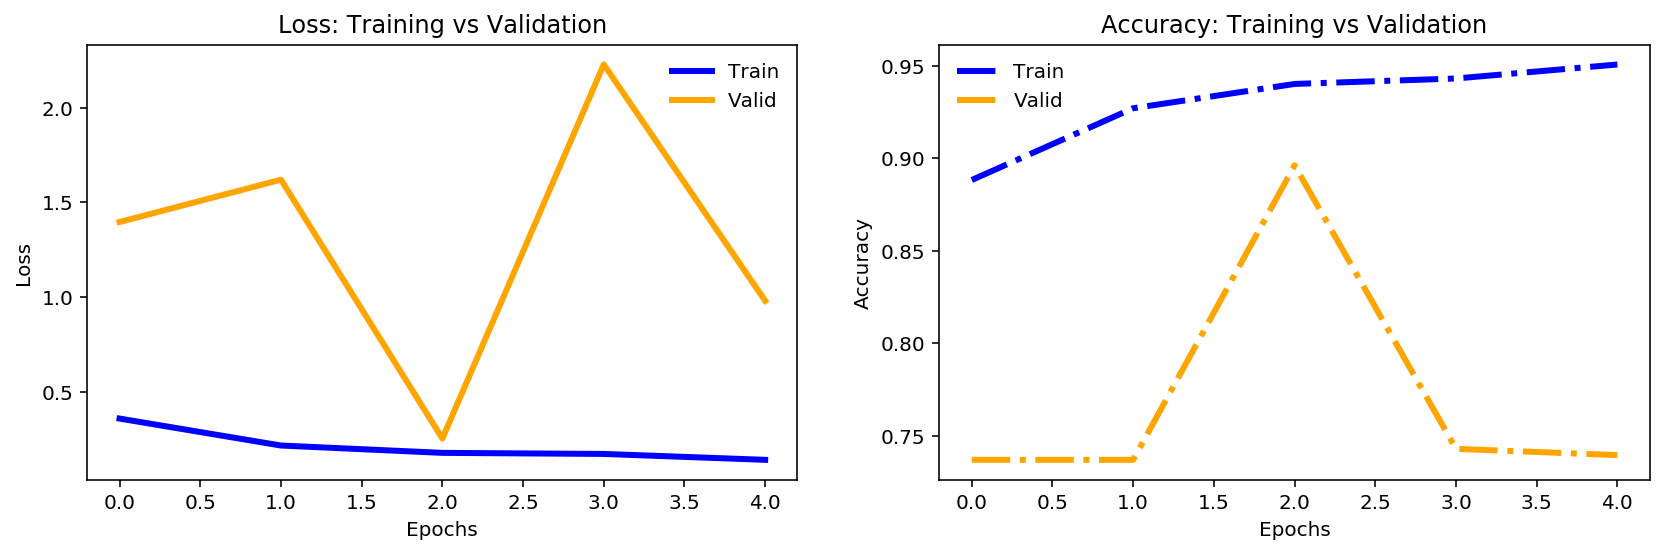

In [30]:
#Initialize Base
from keras.applications.mobilenet_v2 import MobileNetV2
cnn_base = MobileNetV2(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

#Define Model Architecture
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

cnn_base.trainable = False

model.summary()
early_stopping_monitor = EarlyStopping(patience=2) # epochs no improvement

filepath="static/artifacts/model_mobilenetv2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')


#Compilation
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Set the model to train; see warnings above
history = model.fit_generator(
      train_generator,
      steps_per_epoch= num_samples / batch_size,
      epochs=epochs,
      verbose = 0,
      shuffle = True,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint,early_stopping_monitor])

plot_acc_val(history)

### Balanced Dataset Fitting


W2# Initialize Base
from keras.applications.mobilenet_v2 import MobileNetV2
cnn_base = MobileNetV2(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

#Define Model Architecture
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

cnn_base.trainable = False

model.summary()
early_stopping_monitor = EarlyStopping(patience=4) # epochs no improvement

filepath="static/artifacts/model_mobilenetv2_balanced.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')


#Compilation
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Set the model to train; see warnings above
history = model.fit_generator(
      train_generator,
      steps_per_epoch= num_samples / batch_size,
      epochs=epochs,
      verbose = 0,
      shuffle = True,
      class_weight=training_class_weight,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint,early_stopping_monitor])

plot_acc_val(history)

---
<a id='evaluation'></a>
# Evaluation, Discussion, and Next Steps

In [45]:
# Returns saved, compiled model
import glob

performance = {}
for saved_model in glob.glob("static/artifacts/*.hdf5"):
    i = saved_model.split("\\")[-1] #getting the name
    performance[i] = evaluate_test_saved_model(saved_model) #create dictionary of performance metrics

In [47]:
size ={}

for saved_model in glob.glob("static/artifacts/*.hdf5"):
    i = saved_model.split("\\")[-1] #getting the name
    size[i] = int(os.path.getsize(saved_model))/1000000
df_size = pd.DataFrame.from_dict(size, orient='index').round(2)
df_size.columns = ['Size_MB']

The following show each models performance (Precision, Recall, Accuracy, and F1) and its size in MB.

In [48]:
df_performance = pd.DataFrame.from_dict(performance, orient='index').round(3)
df_performance.columns = ['Precision','Recall','Accuracy','F1'] #rename column and format
df_performance
df_evaluation = pd.concat([df_performance,df_size], axis=1)
df_evaluation

,Precision,Recall,Accuracy,F1,Size_MB
model_cnn.hdf5,0.786,0.969,0.816,0.868,13.26
model_cnn_balanced.hdf5,0.821,0.928,0.829,0.871,13.26
model_mobilenetv2.hdf5,0.725,0.962,0.748,0.827,58.42
model_mobilenetv2_balanced.hdf5,0.625,1.000,0.625,0.769,58.42
model_nn_2h_baseline.hdf5,0.785,0.908,0.787,0.842,19.31
model_nn_2h_baseline_balanced.hdf5,0.757,0.918,0.764,0.830,19.31
model_nn_4h_dropout.hdf5,0.776,0.879,0.766,0.825,19.35
model_nn_4h_dropout_balanced.hdf5,0.875,0.592,0.692,0.706,19.35
model_nn_4h__batchnorm.hdf5,0.625,1.000,0.625,0.769,19.38
model_nn_4h__batchnorm_balanced.hdf5,0.755,0.831,0.726,0.791,19.38


**Evaluation and Discussion**

The above table has twelve trained models, demonstrating six different architectures trained with both balanced and unbalanced datasets. The size of each saved model is also provided, since this has implications when deploying the model. It is clear that the VGG19 model at 100MB may challenge a simple microservice without suitable scalable processing. On the contrary, I was a little surprised to see that the CNN is the smallest, and not MobileNetV2. 

Based on our evaluation metrics that we listed at the beginning of the project (though we show accuracy in the model training steps), the best model recall are these with 100% recall on the testing data (unseen by the model in training). This is very important for our particular use case, i.e., if we mistakenly classify a pneumonia patient as healthy, it can result in death, liability, pain,…

1.	model_nn_4h__batchnorm.hdf5
2.	model_mobilenetv2_balanced.hdf5
3.	model_cnn.hdf5

However, the model with the best F1 score, a harmonic mean of the recall and precision, is our CNN. Given that this is to be a diagnostic tool to aid doctors, it may be best to have a more “well-rounded” model, especially considering that the recall scores are so close. 

1.	model_cnn_balanced.hdf5
2.	model_cnn.hdf5
3.	model_nn_2h_baseline.hdf5	

Based on this information, the **selected model at 13.26 MB, is the model_CNN with 96.9% recall and 86.8% F1**. 

**Further Steps**

Improvement upon these models could be achieved by tuning hyperparameters, and in some cases training more epochs. However, in the case of the CNN, changing the architecture to be deeper or wider may serve to increase our model performance. It was interesting to see our simple baseline neural network holding its own against more complicated algorithms- it was almost the most parsimonious tool for the job! However, convolutions clearly show its advantage in image recognition with this problem. 

---
<a id='resources'></a>
# Resources

- https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
- https://towardsdatascience.com/understanding-neural-networks-from-neuron-to-rnn-cnn-and-deep-learning-cd88e90e0a90
- https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf
- https://medium.com/swlh/how-to-use-smote-for-dealing-with-imbalanced-image-dataset-for-solving-classification-problems-3aba7d2b9cad
- https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
- https://stackoverflow.com/questions/52270177/how-to-use-predict-generator-on-new-images-keras?noredirect=1&lq=1
- https://www.youtube.com/watch?v=41JItgtYGDo
- https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/
- https://machinelearningmastery.com/check-point-deep-learning-models-keras/
- https://machinelearningmastery.com/save-load-keras-deep-learning-models/
- https://jovianlin.io/saving-loading-keras-models/
- https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
- https://datascience.stackexchange.com/questions/33008/is-it-always-better-to-use-the-whole-dataset-to-train-the-final-model